# Choose where to run

In [73]:
platform = 'jupyter_notebook' #@param ['colab', 'jupyter_notebook'] {allow-input: true}

if platform == 'colab':
    from google.colab import drive
    drive.mount('/content/drive/', force_remount=True)
    data_dir = '/content/drive/MyDrive/algonauts_2023_tutorial_data' #@param {type:"string"}
    parent_submission_dir = '/content/drive/MyDrive/algonauts_2023_challenge_submission' #@param {type:"string"}

if platform == 'jupyter_notebook':
    data_dir = './algonauts_2023_challenge_data'
    parent_submission_dir = './algonauts_2023_challenge_submission'

# Import

In [74]:
import os
import tensorflow as tf
import numpy as np
from sklearn.decomposition import PCA
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr as corr

# Define dirs

In [75]:
subj_dir = 'subj03'
data_dir = os.path.join(data_dir, subj_dir)
train_img_dir  = os.path.join(data_dir, 'training_split', 'training_images')
test_img_dir  = os.path.join(data_dir, 'test_split', 'test_images')
train_img_list = os.listdir(train_img_dir)

# Create a dataset

In [76]:
batch_size = 300
split = 0.9
num_batches_train = int(len(train_img_list) * split // batch_size)
num_samples_train = int(num_batches_train * batch_size)

def create_dataset_from_image_paths(image_dir):
    dataset = tf.keras.utils.image_dataset_from_directory(image_dir, image_size=(224, 224), labels=None, shuffle=False, batch_size=batch_size)
    # np.expand_dims(x, axis=0) TODO: they use this in docs, but not sure if it's needed, let's try it out
    dataset = dataset.map(tf.keras.applications.resnet50.preprocess_input) # For Alexnet they use tf.keras.layers.experimental.preprocessing.Normalization(mean=[0.485, 0.456, 0.406], variance=[0.229, 0.224, 0.225])
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

dataset = create_dataset_from_image_paths(train_img_dir)
# create train and validation dataset from the training dataset (90% train, 10% validation)
train_dataset = dataset.take(num_batches_train)
val_dataset = dataset.skip(num_batches_train)

test_dataset = create_dataset_from_image_paths(test_img_dir)

print('Training dataset size: ' + str(len(train_dataset)))
print('Validation dataset size: ' + str(len(val_dataset)))
print('Test dataset size: ' + str(len(test_dataset)))

Found 9082 files belonging to 1 classes.
Found 293 files belonging to 1 classes.
Training dataset size: 27
Validation dataset size: 4
Test dataset size: 1


# Define a model and a readout layer

In [77]:
# Take models from here https://keras.io/api/applications/
base_model = tf.keras.applications.ResNet50(weights='imagenet')
for layer in base_model.layers:
    print(layer.name)

model = tf.keras.Model(inputs=base_model.input, outputs=base_model.get_layer('conv5_block3_out').output)

input_5
conv1_pad
conv1_conv
conv1_bn
conv1_relu
pool1_pad
pool1_pool
conv2_block1_1_conv
conv2_block1_1_bn
conv2_block1_1_relu
conv2_block1_2_conv
conv2_block1_2_bn
conv2_block1_2_relu
conv2_block1_0_conv
conv2_block1_3_conv
conv2_block1_0_bn
conv2_block1_3_bn
conv2_block1_add
conv2_block1_out
conv2_block2_1_conv
conv2_block2_1_bn
conv2_block2_1_relu
conv2_block2_2_conv
conv2_block2_2_bn
conv2_block2_2_relu
conv2_block2_3_conv
conv2_block2_3_bn
conv2_block2_add
conv2_block2_out
conv2_block3_1_conv
conv2_block3_1_bn
conv2_block3_1_relu
conv2_block3_2_conv
conv2_block3_2_bn
conv2_block3_2_relu
conv2_block3_3_conv
conv2_block3_3_bn
conv2_block3_add
conv2_block3_out
conv3_block1_1_conv
conv3_block1_1_bn
conv3_block1_1_relu
conv3_block1_2_conv
conv3_block1_2_bn
conv3_block1_2_relu
conv3_block1_0_conv
conv3_block1_3_conv
conv3_block1_0_bn
conv3_block1_3_bn
conv3_block1_add
conv3_block1_out
conv3_block2_1_conv
conv3_block2_1_bn
conv3_block2_1_relu
conv3_block2_2_conv
conv3_block2_2_bn
conv3_

# PCA

In [78]:
pca = PCA(n_components=100)

# Fit PCA to batch of datastet
for batch in tqdm(train_dataset):
    # Extract features
    features = model.predict(batch)
    # Flatten the features
    features = features.reshape(features.shape[0], -1)
    # Fit PCA to batch of features
    pca.fit(features)

  0%|          | 0/27 [00:00<?, ?it/s]

10/10 [==============================] - 2s 69ms/step


  4%|▎         | 1/27 [00:14<06:15, 14.43s/it]

10/10 [==============================] - 1s 69ms/step


  7%|▋         | 2/27 [00:20<03:51,  9.24s/it]

10/10 [==============================] - 1s 68ms/step


 11%|█         | 3/27 [00:25<03:01,  7.58s/it]

10/10 [==============================] - 1s 69ms/step


 15%|█▍        | 4/27 [00:32<02:44,  7.14s/it]

10/10 [==============================] - 1s 71ms/step


 19%|█▊        | 5/27 [00:37<02:19,  6.34s/it]

10/10 [==============================] - 1s 69ms/step


 22%|██▏       | 6/27 [00:42<02:07,  6.06s/it]

10/10 [==============================] - 1s 69ms/step


 26%|██▌       | 7/27 [00:47<01:57,  5.86s/it]

10/10 [==============================] - 1s 68ms/step


 30%|██▉       | 8/27 [00:53<01:46,  5.61s/it]

10/10 [==============================] - 1s 67ms/step


 33%|███▎      | 9/27 [00:57<01:36,  5.37s/it]

10/10 [==============================] - 1s 70ms/step


 37%|███▋      | 10/27 [01:03<01:30,  5.31s/it]

10/10 [==============================] - 1s 67ms/step


 41%|████      | 11/27 [01:07<01:22,  5.14s/it]

10/10 [==============================] - 1s 69ms/step


 44%|████▍     | 12/27 [01:13<01:17,  5.16s/it]

10/10 [==============================] - 1s 70ms/step


 48%|████▊     | 13/27 [01:17<01:10,  5.01s/it]

10/10 [==============================] - 1s 70ms/step


 52%|█████▏    | 14/27 [01:22<01:04,  4.99s/it]

10/10 [==============================] - 1s 69ms/step


 56%|█████▌    | 15/27 [01:27<01:00,  5.07s/it]

10/10 [==============================] - 1s 68ms/step


 59%|█████▉    | 16/27 [01:33<00:56,  5.14s/it]

10/10 [==============================] - 1s 69ms/step


 63%|██████▎   | 17/27 [01:38<00:50,  5.06s/it]

10/10 [==============================] - 1s 69ms/step


 67%|██████▋   | 18/27 [01:43<00:46,  5.15s/it]

10/10 [==============================] - 1s 69ms/step


 70%|███████   | 19/27 [01:48<00:42,  5.27s/it]

10/10 [==============================] - 1s 69ms/step


 74%|███████▍  | 20/27 [01:54<00:36,  5.28s/it]

10/10 [==============================] - 1s 68ms/step


 78%|███████▊  | 21/27 [01:58<00:29,  4.96s/it]

10/10 [==============================] - 1s 69ms/step


 81%|████████▏ | 22/27 [02:02<00:23,  4.72s/it]

10/10 [==============================] - 1s 69ms/step


 85%|████████▌ | 23/27 [02:07<00:18,  4.63s/it]

10/10 [==============================] - 1s 69ms/step


 89%|████████▉ | 24/27 [02:11<00:13,  4.66s/it]

10/10 [==============================] - 1s 69ms/step


 93%|█████████▎| 25/27 [02:16<00:09,  4.58s/it]

10/10 [==============================] - 1s 69ms/step


 96%|█████████▋| 26/27 [02:20<00:04,  4.56s/it]

10/10 [==============================] - 1s 70ms/step


100%|██████████| 27/27 [03:21<00:00,  7.48s/it]


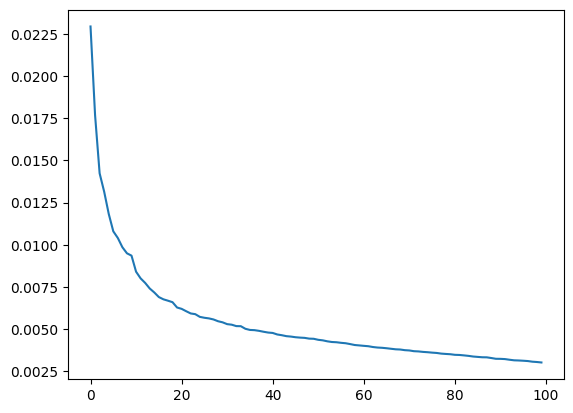

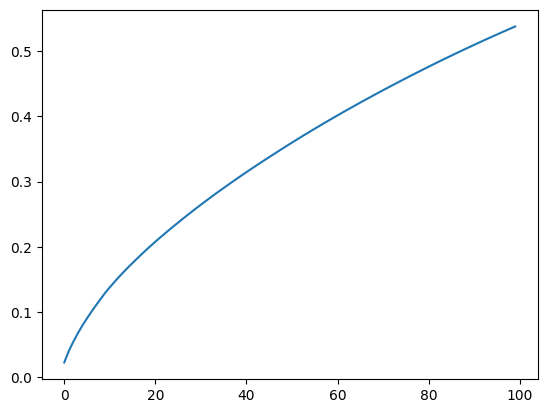

In [79]:
# plot the explained variance
plt.plot(pca.explained_variance_ratio_)
plt.show()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.show()

In [80]:
def extract_features(dataset, model, pca):
    features = []
    for batch in tqdm(dataset):
        ft = model.predict(batch)
        # Flatten the features
        ft = ft.reshape(ft.shape[0], -1)
        # Fit PCA to batch of features
        ft = pca.transform(ft)
        features.append(ft)
    return np.vstack(features) # why do we need to stack the features? will .extend() work?


In [81]:
features_train = extract_features(train_dataset, model, pca)
features_val = extract_features(val_dataset, model, pca)
features_test = extract_features(test_dataset, model, pca)

  0%|          | 0/27 [00:00<?, ?it/s]

10/10 [==============================] - 1s 72ms/step


  4%|▎         | 1/27 [00:05<02:22,  5.46s/it]

10/10 [==============================] - 1s 69ms/step


  7%|▋         | 2/27 [00:08<01:43,  4.13s/it]

10/10 [==============================] - 1s 76ms/step


 11%|█         | 3/27 [00:10<01:14,  3.08s/it]

10/10 [==============================] - 1s 69ms/step


 15%|█▍        | 4/27 [00:12<01:01,  2.67s/it]

10/10 [==============================] - 1s 73ms/step


 19%|█▊        | 5/27 [00:13<00:47,  2.15s/it]

10/10 [==============================] - 1s 69ms/step


 22%|██▏       | 6/27 [00:15<00:42,  2.01s/it]

10/10 [==============================] - 1s 71ms/step


 26%|██▌       | 7/27 [00:17<00:37,  1.86s/it]

10/10 [==============================] - 1s 71ms/step


 30%|██▉       | 8/27 [00:18<00:32,  1.73s/it]

10/10 [==============================] - 1s 70ms/step


 33%|███▎      | 9/27 [00:19<00:29,  1.64s/it]

10/10 [==============================] - 1s 69ms/step


 37%|███▋      | 10/27 [00:21<00:26,  1.56s/it]

10/10 [==============================] - 1s 70ms/step


 41%|████      | 11/27 [00:22<00:23,  1.47s/it]

10/10 [==============================] - 1s 70ms/step


 44%|████▍     | 12/27 [00:23<00:21,  1.44s/it]

10/10 [==============================] - 1s 70ms/step


 48%|████▊     | 13/27 [00:25<00:19,  1.39s/it]

10/10 [==============================] - 1s 68ms/step


 52%|█████▏    | 14/27 [00:26<00:17,  1.38s/it]

10/10 [==============================] - 1s 68ms/step


 56%|█████▌    | 15/27 [00:27<00:16,  1.35s/it]

10/10 [==============================] - 1s 70ms/step


 59%|█████▉    | 16/27 [00:29<00:14,  1.35s/it]

10/10 [==============================] - 1s 67ms/step


 63%|██████▎   | 17/27 [00:30<00:14,  1.42s/it]

10/10 [==============================] - 1s 71ms/step


 67%|██████▋   | 18/27 [00:32<00:13,  1.53s/it]

10/10 [==============================] - 1s 71ms/step


 70%|███████   | 19/27 [00:33<00:11,  1.49s/it]

10/10 [==============================] - 1s 71ms/step


 74%|███████▍  | 20/27 [00:35<00:10,  1.43s/it]

10/10 [==============================] - 1s 67ms/step


 78%|███████▊  | 21/27 [00:36<00:08,  1.36s/it]

10/10 [==============================] - 1s 69ms/step


 81%|████████▏ | 22/27 [00:37<00:06,  1.29s/it]

10/10 [==============================] - 1s 69ms/step


 85%|████████▌ | 23/27 [00:38<00:05,  1.28s/it]

10/10 [==============================] - 1s 69ms/step


 89%|████████▉ | 24/27 [00:40<00:03,  1.25s/it]

10/10 [==============================] - 1s 69ms/step


 93%|█████████▎| 25/27 [00:41<00:02,  1.35s/it]

10/10 [==============================] - 1s 69ms/step


 96%|█████████▋| 26/27 [00:43<00:01,  1.43s/it]

10/10 [==============================] - 1s 69ms/step


  0%|          | 0/4 [00:00<?, ?it/s]

10/10 [==============================] - 1s 69ms/step


 25%|██▌       | 1/4 [00:21<01:03, 21.18s/it]

10/10 [==============================] - 1s 70ms/step


 50%|█████     | 2/4 [00:22<00:18,  9.39s/it]

10/10 [==============================] - 1s 69ms/step


 75%|███████▌  | 3/4 [00:23<00:05,  5.82s/it]

3/3 [==============================] - 0s 195ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 1s 89ms/step


100%|██████████| 1/1 [00:03<00:00,  3.01s/it]


In [82]:
del model, pca

# Handle frmi files

In [83]:
fmri_dir = os.path.join(data_dir, 'training_split', 'training_fmri')
lh_fmri = np.load(os.path.join(fmri_dir, 'lh_training_fmri.npy'))
rh_fmri = np.load(os.path.join(fmri_dir, 'rh_training_fmri.npy'))

print('LH training fMRI data shape:')
print(lh_fmri.shape)
print('(Training stimulus images × LH vertices)')

print('\nRH training fMRI data shape:')
print(rh_fmri.shape)
print('(Training stimulus images × RH vertices)')

LH training fMRI data shape:
(9082, 19004)
(Training stimulus images × LH vertices)

RH training fMRI data shape:
(9082, 20544)
(Training stimulus images × RH vertices)


In [84]:
lh_fmri_train = lh_fmri[:num_samples_train]
lh_fmri_val = lh_fmri[num_samples_train:]
rh_fmri_train = rh_fmri[:num_samples_train]
rh_fmri_val = rh_fmri[num_samples_train:]

In [85]:
del lh_fmri, rh_fmri

# Fitting regression

In [86]:
reg_lh = LinearRegression().fit(features_train, lh_fmri_train)
reg_rh = LinearRegression().fit(features_train, rh_fmri_train)
# Use fitted linear regressions to predict the validation and test fMRI data
lh_fmri_val_pred = reg_lh.predict(features_val)
lh_fmri_test_pred = reg_lh.predict(features_test)
rh_fmri_val_pred = reg_rh.predict(features_val)
rh_fmri_test_pred = reg_rh.predict(features_test)

# Calculating correlation

In [87]:
# Empty correlation array of shape: (LH vertices)
lh_correlation = np.zeros(lh_fmri_val_pred.shape[1])
# Correlate each predicted LH vertex with the corresponding ground truth vertex
for v in tqdm(range(lh_fmri_val_pred.shape[1])):
    lh_correlation[v] = corr(lh_fmri_val_pred[:,v], lh_fmri_val[:,v])[0]

# Empty correlation array of shape: (RH vertices)
rh_correlation = np.zeros(rh_fmri_val_pred.shape[1])
# Correlate each predicted RH vertex with the corresponding ground truth vertex
for v in tqdm(range(rh_fmri_val_pred.shape[1])):
    rh_correlation[v] = corr(rh_fmri_val_pred[:,v], rh_fmri_val[:,v])[0]

print(f'Left hemisphere median correlation: {np.median(lh_correlation)}')
print(f'Right hemisphere median correlation: {np.median(rh_correlation)}')

100%|██████████| 20544/20544 [00:02<00:00, 7480.11it/s]

Left hemisphere median correlation: 0.3464783974180009
Right hemisphere median correlation: 0.33730766186344296


# Visualize

/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


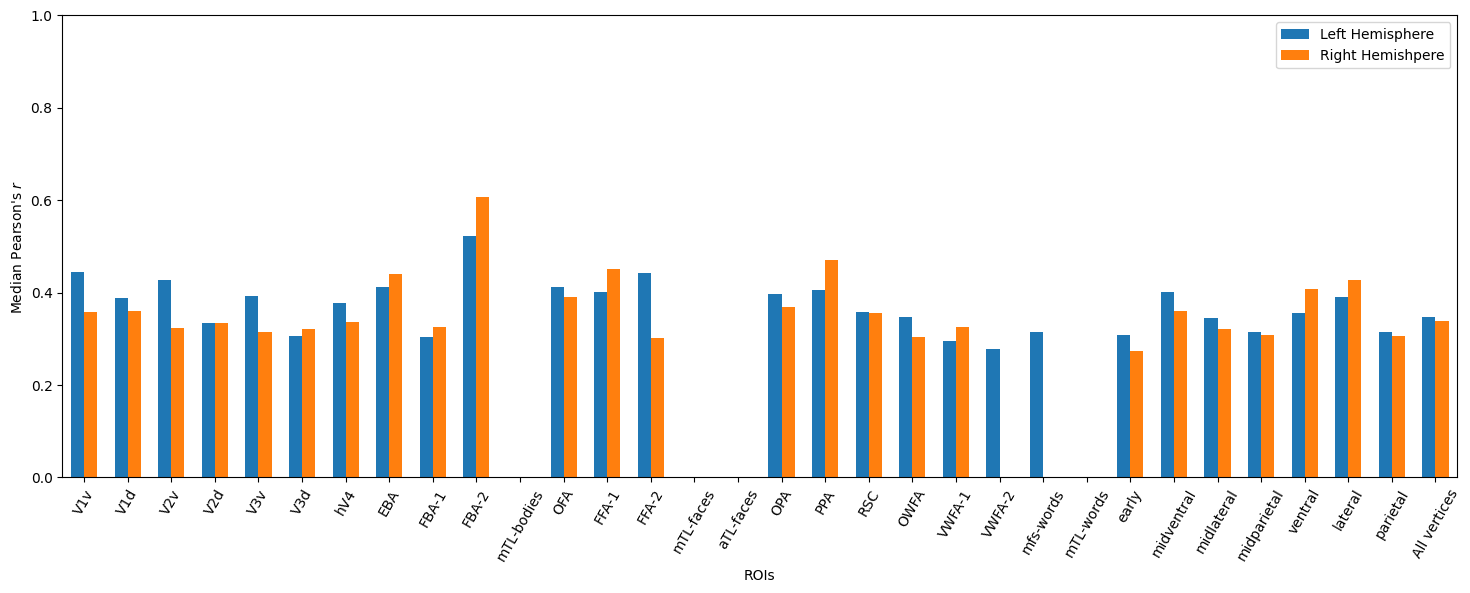

In [88]:
# Load the ROI classes mapping dictionaries
roi_mapping_files = ['mapping_prf-visualrois.npy', 'mapping_floc-bodies.npy',
    'mapping_floc-faces.npy', 'mapping_floc-places.npy',
    'mapping_floc-words.npy', 'mapping_streams.npy']
roi_name_maps = []
for r in roi_mapping_files:
    roi_name_maps.append(np.load(os.path.join(data_dir, 'roi_masks', r),
        allow_pickle=True).item())

# Load the ROI brain surface maps
lh_challenge_roi_files = ['lh.prf-visualrois_challenge_space.npy',
    'lh.floc-bodies_challenge_space.npy', 'lh.floc-faces_challenge_space.npy',
    'lh.floc-places_challenge_space.npy', 'lh.floc-words_challenge_space.npy',
    'lh.streams_challenge_space.npy']
rh_challenge_roi_files = ['rh.prf-visualrois_challenge_space.npy',
    'rh.floc-bodies_challenge_space.npy', 'rh.floc-faces_challenge_space.npy',
    'rh.floc-places_challenge_space.npy', 'rh.floc-words_challenge_space.npy',
    'rh.streams_challenge_space.npy']
lh_challenge_rois = []
rh_challenge_rois = []
for r in range(len(lh_challenge_roi_files)):
    lh_challenge_rois.append(np.load(os.path.join(data_dir, 'roi_masks',
        lh_challenge_roi_files[r])))
    rh_challenge_rois.append(np.load(os.path.join(data_dir, 'roi_masks',
        rh_challenge_roi_files[r])))

# Select the correlation results vertices of each ROI
roi_names = []
lh_roi_correlation = []
rh_roi_correlation = []
for r1 in range(len(lh_challenge_rois)):
    for r2 in roi_name_maps[r1].items():
        if r2[0] != 0: # zeros indicate to vertices falling outside the ROI of interest
            roi_names.append(r2[1])
            lh_roi_idx = np.where(lh_challenge_rois[r1] == r2[0])[0]
            rh_roi_idx = np.where(rh_challenge_rois[r1] == r2[0])[0]
            lh_roi_correlation.append(lh_correlation[lh_roi_idx])
            rh_roi_correlation.append(rh_correlation[rh_roi_idx])
roi_names.append('All vertices')
lh_roi_correlation.append(lh_correlation)
rh_roi_correlation.append(rh_correlation)

# Create the plot
lh_median_roi_correlation = [np.median(lh_roi_correlation[r])
    for r in range(len(lh_roi_correlation))]
rh_median_roi_correlation = [np.median(rh_roi_correlation[r])
    for r in range(len(rh_roi_correlation))]
plt.figure(figsize=(18,6))
x = np.arange(len(roi_names))
width = 0.30
plt.bar(x - width/2, lh_median_roi_correlation, width, label='Left Hemisphere')
plt.bar(x + width/2, rh_median_roi_correlation, width,
    label='Right Hemishpere')
plt.xlim(left=min(x)-.5, right=max(x)+.5)
plt.ylim(bottom=0, top=1)
plt.xlabel('ROIs')
plt.xticks(ticks=x, labels=roi_names, rotation=60)
plt.ylabel('Median Pearson\'s $r$')
plt.legend(frameon=True, loc=1)

# Submission

In [89]:
lh_fmri_test_pred = lh_fmri_test_pred.astype(np.float32)
rh_fmri_test_pred = rh_fmri_test_pred.astype(np.float32)

In [90]:
subject_submission_dir = os.path.join(parent_submission_dir, subj_dir)
np.save(os.path.join(subject_submission_dir, 'lh_pred_test.npy'), lh_fmri_test_pred)
np.save(os.path.join(subject_submission_dir, 'rh_pred_test.npy'), rh_fmri_test_pred)